In [1]:

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from keras.layers import concatenate
import torch
import pandas as pd
import os
from tensorflow.python.client import device_lib 
import matplotlib.pyplot as plt

# Conform that my computer has GPU, and set the memory can be use.
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)


print(device_lib.list_local_devices()) 
  

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14053625360060870538
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5815402496
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15056834592571583065
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [2]:
import os

    # Check if the item in the directory is a folder, iterate through each image file in the folder
    # Then create the full path to the image file,  append the image path and labels.

data = "./archive"
file_path = []
labels = []

for folder in os.listdir(data):
    folder_path = os.path.join(data, folder)
    if os.path.isdir(folder_path):
        for image in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image)
            file_path.append(image_path)
            labels.append(folder.split(' ')[0])


file_paths_series = pd.Series(file_path, name='filepaths')
labels_series = pd.Series(labels, name='labels')

df = pd.concat([file_paths_series, labels_series], axis=1)

df.head()

,filepaths,labels
0,./archive\Astrocitoma T1\005_big_gallery.jpeg,Astrocitoma
1,./archive\Astrocitoma T1\006_big_gallery.jpeg,Astrocitoma
2,./archive\Astrocitoma T1\01809e58d2c1e7fff56cc...,Astrocitoma
3,./archive\Astrocitoma T1\02df132a56dfb89ece42e...,Astrocitoma
4,./archive\Astrocitoma T1\044d8d9984902ca03e652...,Astrocitoma


In [3]:
#shows the image class and total number of each class
print(df['labels'].unique())
print(df['labels'].value_counts())


['Astrocitoma' 'Carcinoma' 'Ependimoma' 'Ganglioglioma' 'Germinoma'
 'Glioblastoma' 'Granuloma' 'Meduloblastoma' 'Meningioma' 'Neurocitoma'
 'Oligodendroglioma' 'Papiloma' 'Schwannoma' 'Tuberculoma' '_NORMAL']
labels
Meningioma           874
Astrocitoma          580
_NORMAL              522
Schwannoma           465
Neurocitoma          457
Carcinoma            251
Papiloma             237
Oligodendroglioma    224
Glioblastoma         204
Ependimoma           150
Tuberculoma          145
Meduloblastoma       131
Germinoma            100
Granuloma             78
Ganglioglioma         61
Name: count, dtype: int64


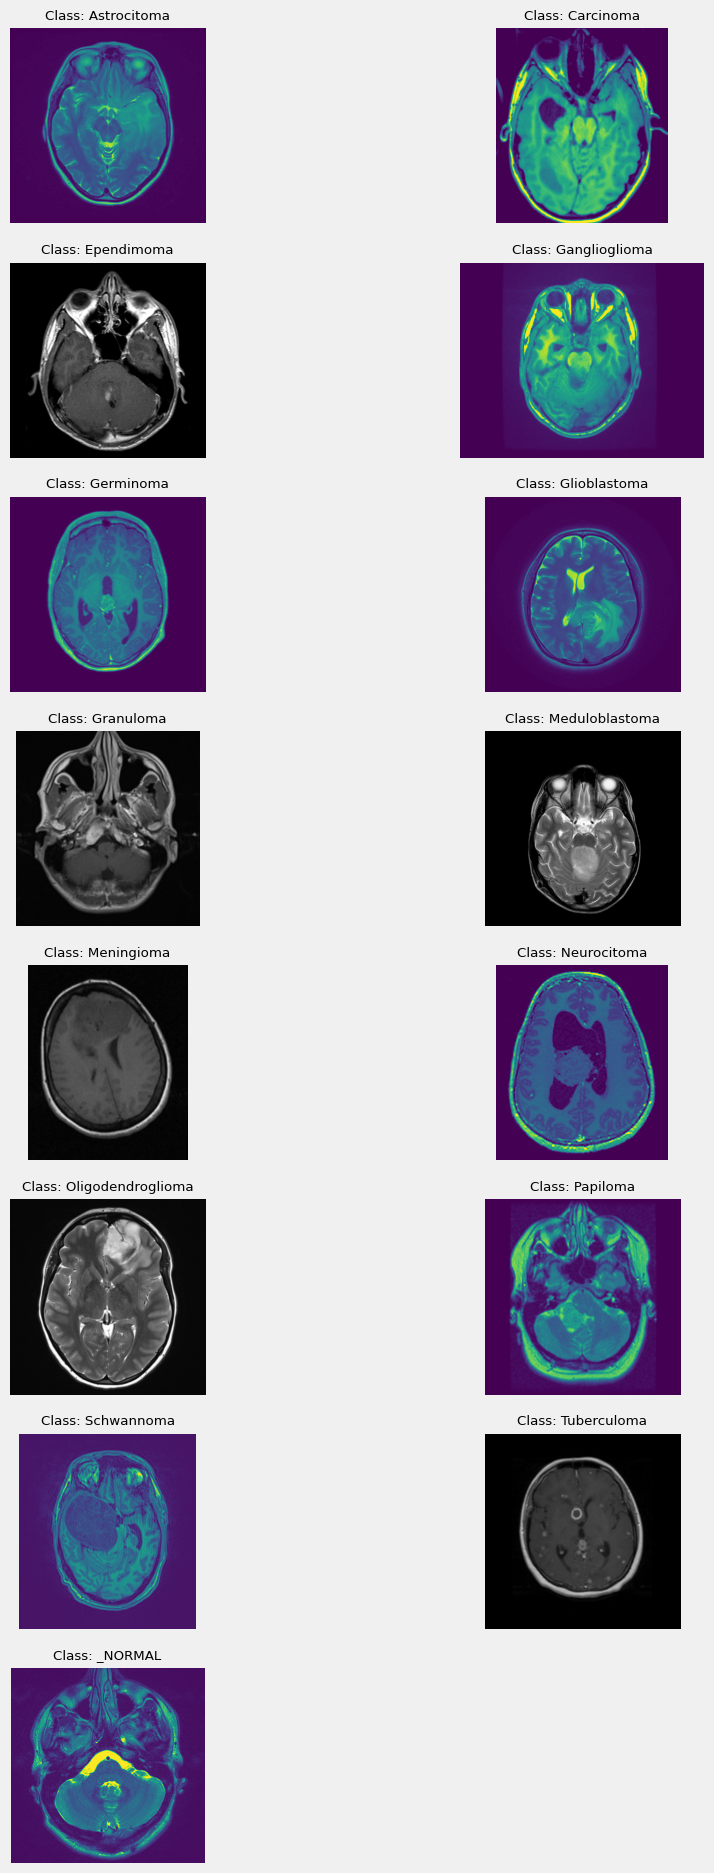

In [34]:



#Show the first image on the class. 
classes = df['labels'].unique()
num_classes = len(classes)
plt.figure(figsize=(10, 40))
for i, class_label in enumerate(classes):
    class_image = df[df['labels'] == class_label]['filepaths'].sample(1).values[0]
    plt.subplot(14, min(2, num_classes), i+1)
    img = plt.imread(class_image)
    plt.imshow(img)
    plt.title(f'Class: {class_label}')
    plt.axis('off')
plt.show()


In [5]:
#train test split
# we will need train, test and validate data
# so it will be training 70% testing 18% validation 12%
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df,train_size=0.7,shuffle=True, stratify=df['labels'] ,random_state=24)
test_data, vaild_data = train_test_split(test_data,train_size=0.6,shuffle=True,stratify=test_data['labels'],random_state=24)


In [6]:
print("Training image:", len(train_data))
print("Testing image:", len(test_data))
print("Validation image:", len(vaild_data))

Training image: 3135
Testing image: 806
Validation image: 538


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def IMG(a):
    return a

# Calculate the test data length, and make the batch size no biggter than 80

testlen = len(test_data)
test_size = max(sorted([testlen // x for x in range(1,testlen+1) if testlen%x == 0 and testlen/x <= 80]))
genrator = ImageDataGenerator(preprocessing_function= IMG) #Data Propressoring.
train_data = genrator.flow_from_dataframe(train_data,x_col="filepaths",y_col='labels',class_mode='categorical',color_mode='rgb',shuffle= True,target_size=(224, 224),batch_size=32)
test_data = genrator.flow_from_dataframe(test_data,x_col="filepaths",y_col='labels',class_mode='categorical',color_mode='rgb',shuffle= False,target_size=(224, 224),batch_size=test_size)
valid_data = genrator.flow_from_dataframe(vaild_data,x_col="filepaths",y_col='labels',class_mode='categorical',color_mode='rgb',shuffle= True,target_size=(224, 224),batch_size=32)



Found 3135 validated image filenames belonging to 15 classes.
Found 806 validated image filenames belonging to 15 classes.


Found 537 validated image filenames belonging to 15 classes.


c:\ProgramData\Anaconda3\envs\tf_env\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


#################################################################

At this part, will start to build the GoogLeNet model Base on :
https://lekhuyen.medium.com/implementation-of-googlenet-on-keras-d9873aeed83c



##################################################################

In [8]:
#

def Inception_Group(input_layer,L_11,L_21,L_23,R_11,R_15,R_M1):

    #L1 first one on the left
    L_1 = Conv2D(filters=L_11,kernel_size=(1,1),padding='same',activation='relu')(input_layer)
    #L2 Second one on the left
    L_2 =Conv2D(filters=L_21,kernel_size=(1,1),padding='same',activation='relu')(input_layer)
    L_2 =Conv2D(filters=L_23,kernel_size=(3,3),padding='same',activation='relu')(L_2)

    #L3 first one on the right
    L_3 = Conv2D(filters=R_11,kernel_size=(1,1),padding='same',activation='relu')(input_layer)
    L_3 = Conv2D(filters=R_15,kernel_size=(5,5),padding='same',activation='relu')(L_3)

    #L4 Second one on the right
    L_4 = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same')(input_layer)
    L_4 = Conv2D(filters=R_M1,kernel_size=(5,5),padding='same',activation='relu')(L_4)

    #DepthConcat
    output_layer = concatenate([L_1,L_2,L_3,L_4],axis=-1)

    return output_layer


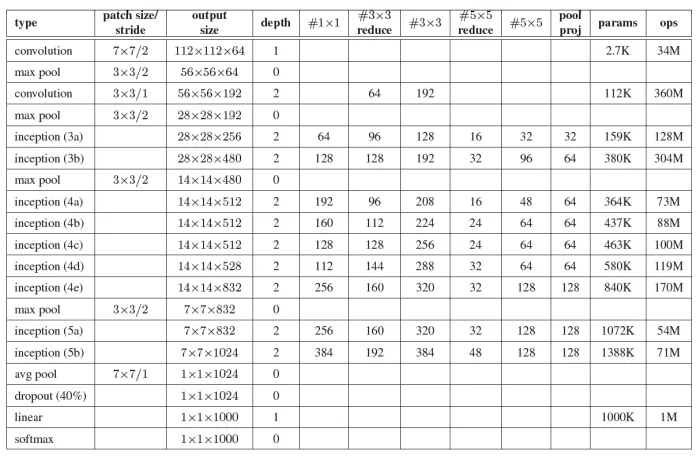

In [9]:
def GoogLeNet():
    input_layer = Input(shape=(224,224,3))

    input = Conv2D(filters=64,kernel_size=(7,7),padding='valid',activation='relu')(input_layer)
    input = MaxPooling2D(pool_size=(3,3),strides=2)(input)
    input = Conv2D(filters=64,kernel_size=(1,1),padding='same',activation='relu')(input)
    input = Conv2D(filters=192,kernel_size=(3,3),padding='same',activation='relu')(input)
    input = MaxPooling2D(pool_size=(3,3),strides=2)(input)

    input = Inception_Group(input,64,96,128,16,32,32)
    input = Inception_Group(input,128,128,192,32,96,64)
    input = MaxPooling2D(pool_size=(3,3),strides=2)(input)
    input = Inception_Group(input,192,96,208,16,48,46)

    out_1 = AveragePooling2D(pool_size=(5,5),strides=3)(input)
    out_1 = Conv2D(filters=128,kernel_size=(1,1),padding='same',activation='relu')(out_1)
    out_1 = Flatten()(out_1)
    out_1 = Dense(1024,activation='relu')(out_1)
    out_1 = Dropout(0.7)(out_1)
    out_1 = Dense(15,activation='softmax')(out_1)

    input = Inception_Group(input,160,112,224,24,64,64)
    input = Inception_Group(input,128,128,256,24,64,64)
    input = Inception_Group(input,112,144,288,32,64,64)

    out_2 = AveragePooling2D(pool_size=(5,5),strides=3)(input)
    out_2 = Conv2D(filters=128,kernel_size=(1,1),padding='same',activation='relu')(out_2)
    out_2 = Flatten()(out_2)
    out_2 = Dense(1024,activation='relu')(out_2)
    out_2 = Dropout(0.7)(out_2)
    out_2 = Dense(15,activation='softmax')(out_2)

    input = Inception_Group(input,256,160,320,32,128,128)
    input = MaxPooling2D(pool_size=(3,3),strides=2)(input)
    input = Inception_Group(input,256,160,320,32,128,128)
    input = Inception_Group(input,384,192,384,48,128,128)

    input = GlobalAveragePooling2D(name='GAPL')(input)
    input = Dropout(0.4)(input)
    input = Dense(15,activation='softmax')(input)

    model = Model(input_layer,[input,out_1,out_2],name = 'GoogLeNet')

    return model



#################################################################################################################

In [10]:
model = GoogLeNet()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 218, 218, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 108, 108, 64  0           ['conv2d[0][0]']                 
                                )                                                         

In [11]:
import datetime

time_for_training = datetime.datetime.now()

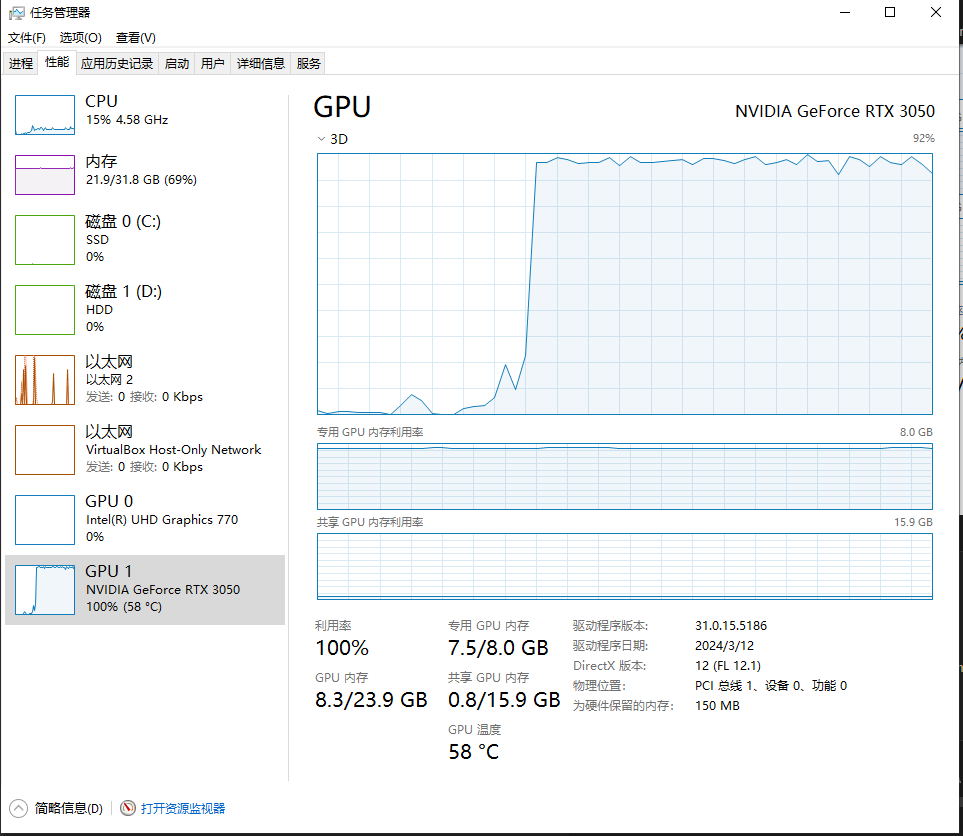
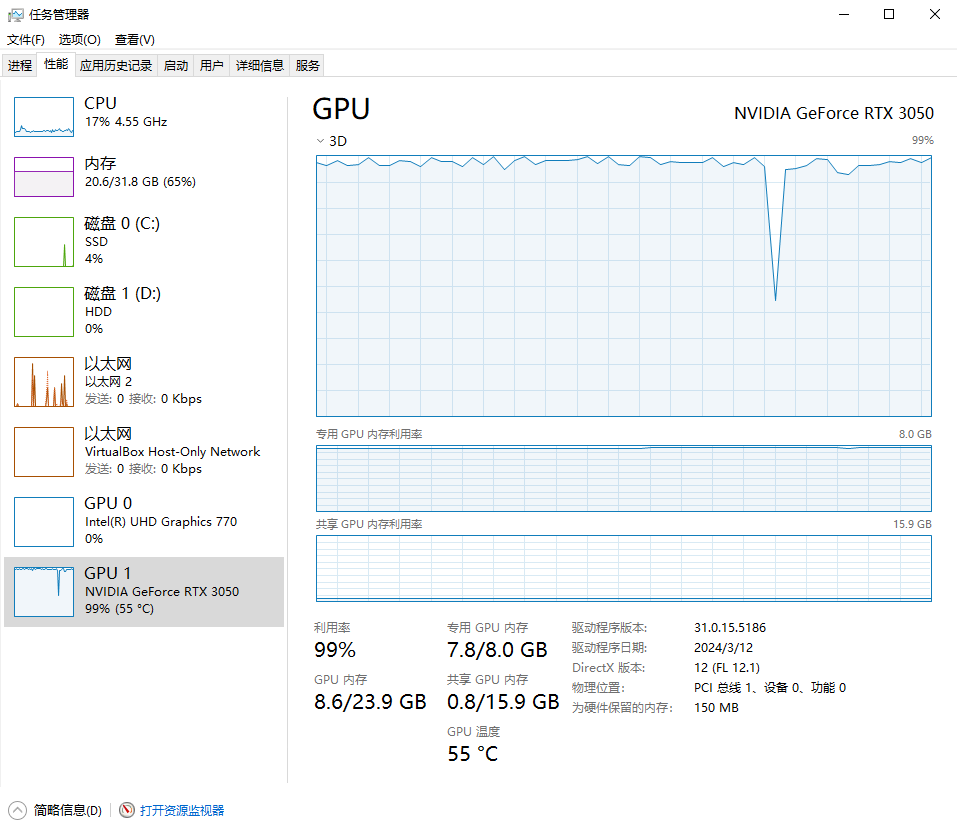

In [12]:
history = model.fit(
    train_data,
    epochs=100,
    validation_data=valid_data
)
time_after_training = datetime.datetime.now()
model.save("googlenet_model2_1.h5")


Epoch 1/100
98/98 [==============================] - 117s 898ms/step - loss: 14.5855 - dense_4_loss: 7.7525 - dense_1_loss: 3.4342 - dense_3_loss: 3.3988 - dense_4_accuracy: 0.1885 - dense_1_accuracy: 0.1860 - dense_3_accuracy: 0.1777 - val_loss: 7.1049 - val_dense_4_loss: 2.4460 - val_dense_1_loss: 2.2546 - val_dense_3_loss: 2.4044 - val_dense_4_accuracy: 0.1955 - val_dense_1_accuracy: 0.2980 - val_dense_3_accuracy: 0.2030
Epoch 2/100
98/98 [==============================] - 58s 596ms/step - loss: 6.9716 - dense_4_loss: 2.4610 - dense_1_loss: 2.2136 - dense_3_loss: 2.2970 - dense_4_accuracy: 0.1914 - dense_1_accuracy: 0.2836 - dense_3_accuracy: 0.2632 - val_loss: 6.7923 - val_dense_4_loss: 2.4355 - val_dense_1_loss: 2.1604 - val_dense_3_loss: 2.1963 - val_dense_4_accuracy: 0.1955 - val_dense_1_accuracy: 0.3073 - val_dense_3_accuracy: 0.3166
Epoch 3/100
98/98 [==============================] - 59s 599ms/step - loss: 6.4325 - dense_4_loss: 2.3957 - dense_1_loss: 1.9977 - dense_3_loss: 2

In [13]:
total_traintime = time_after_training-time_for_training
total_minutes = total_traintime.total_seconds() // 60
total_seconds = total_traintime.total_seconds() % 60

# Print the total training time in minutes and seconds
print("Total training time:", total_minutes, "minutes and", total_seconds, "seconds")

Total training time: 96.0 minutes and 46.49488199999996 seconds


In [15]:
print(history.history.keys())

dict_keys(['loss', 'dense_4_loss', 'dense_1_loss', 'dense_3_loss', 'dense_4_accuracy', 'dense_1_accuracy', 'dense_3_accuracy', 'val_loss', 'val_dense_4_loss', 'val_dense_1_loss', 'val_dense_3_loss', 'val_dense_4_accuracy', 'val_dense_1_accuracy', 'val_dense_3_accuracy'])


In [28]:

def plot_training(history, acc_key, loss_key, val_acc_key, val_loss_key):
 
    tr_acc = history.history[acc_key]
    tr_loss = history.history[loss_key]
    val_acc = history.history[val_acc_key]
    val_loss = history.history[val_loss_key]
    
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    
    epochs = range(1, len(tr_acc) + 1)
    loss_label = f'Best Loss Epoch: {index_loss + 1}'
    acc_label = f'Best Acc Epoch: {index_acc + 1}'

    plt.figure(figsize=(14, 6))
    plt.style.use('seaborn-v0_8-paper')

    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'g', label='Validation Loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=f"{acc_label}, {acc_highest:.4f}")
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

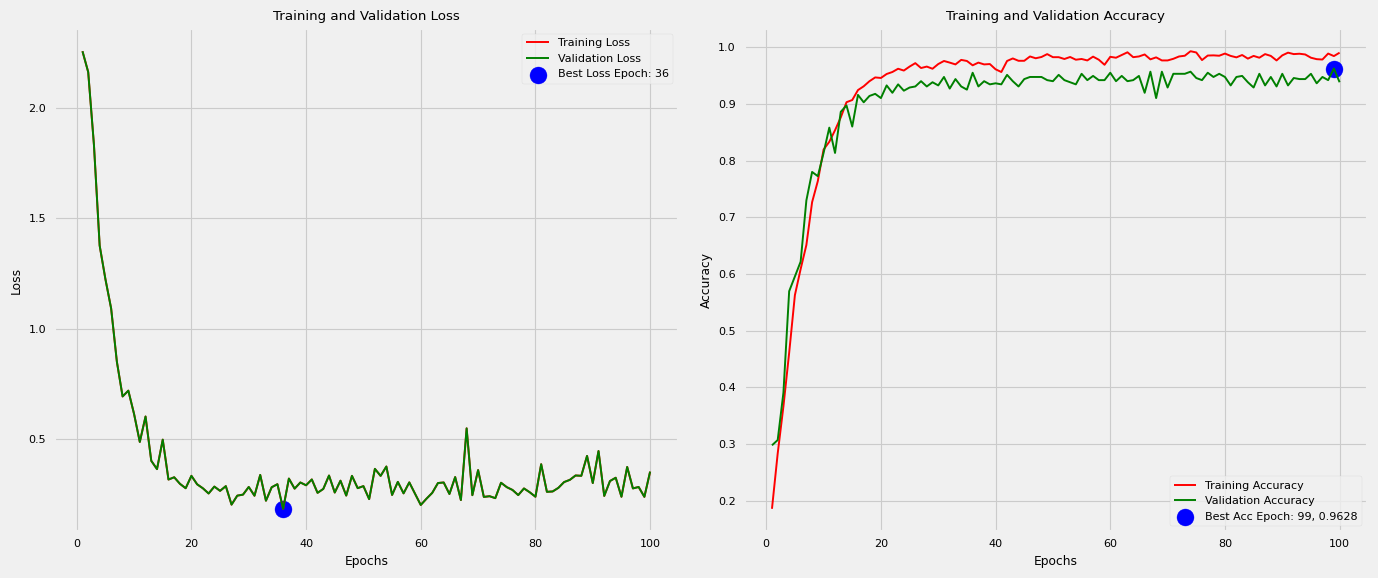

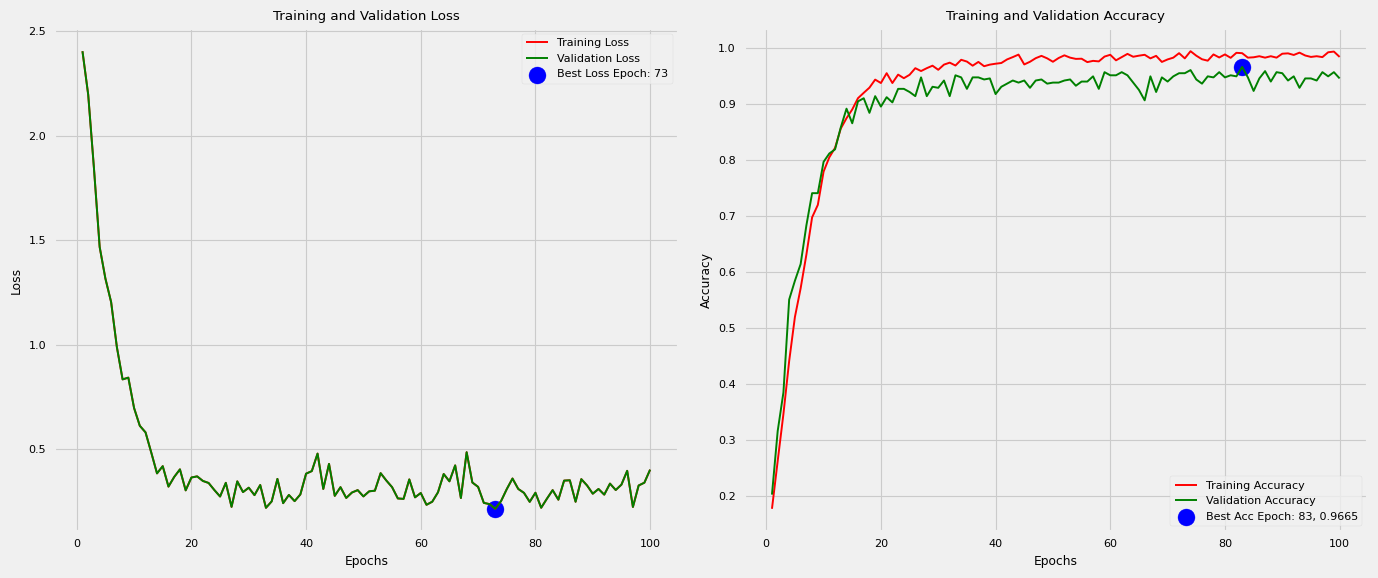

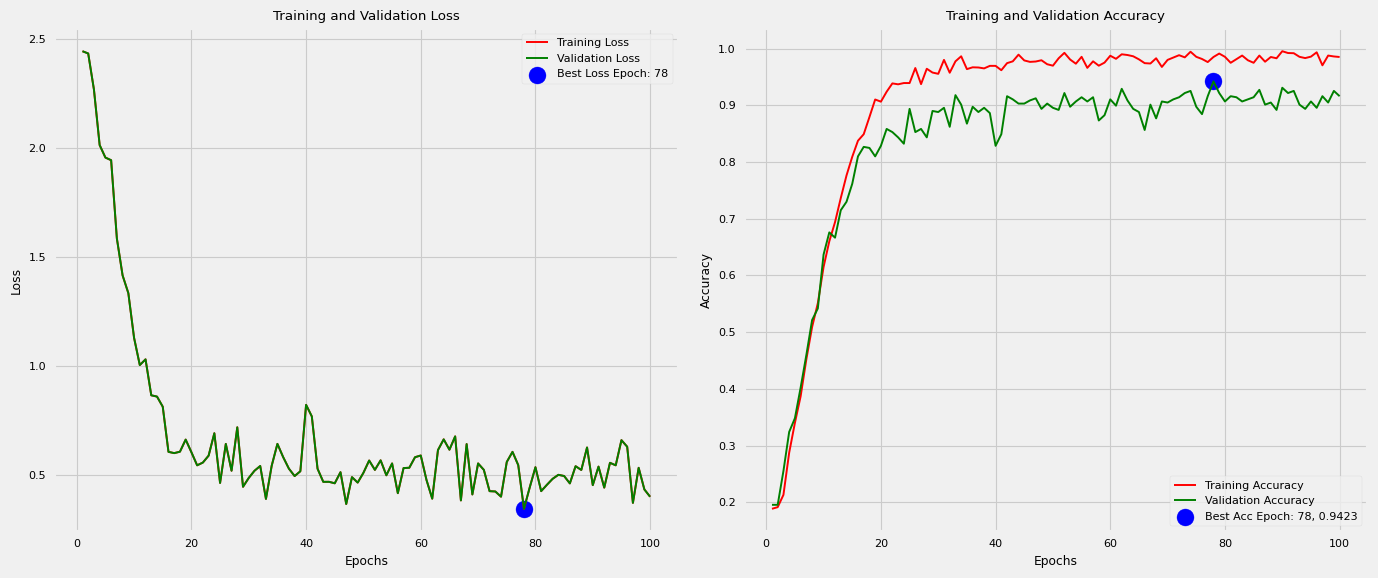

In [30]:
plot_training(history,'dense_1_accuracy','val_dense_1_loss','val_dense_1_accuracy','val_dense_1_loss')
plot_training(history,'dense_3_accuracy','val_dense_3_loss','val_dense_3_accuracy','val_dense_3_loss')
plot_training(history,'dense_4_accuracy','val_dense_4_loss','val_dense_4_accuracy','val_dense_4_loss')

In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score


predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions[0], axis=1)
true_labels = test_data.labels

cm = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(cm)

accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy:.2f}")

13/13 [==============================] - 12s 230ms/step
Confusion Matrix:
[[ 99   0   0   0   0   0   0   0   3   1   0   0   1   0   0]
 [  0  43   0   0   0   0   0   0   2   0   0   0   0   0   0]
 [  0   0  23   0   0   0   0   0   2   0   0   0   2   0   0]
 [  2   0   0   9   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0  16   0   0   0   0   1   0   0   0   0   0]
 [  0   0   0   0   0  35   0   0   2   0   0   0   0   0   0]
 [  2   0   0   0   0   0  12   0   1   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0  18   2   0   0   0   2   0   0]
 [  5   1   0   0   0   2   0   0 138   3   3   1   3   0   1]
 [  1   0   0   0   0   0   0   0   3  76   0   0   2   0   0]
 [  1   0   0   0   0   0   0   0   1   0  38   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0  39   2   1   0]
 [  0   0   0   0   0   0   0   1   3   1   0   0  78   0   1]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1  25   0]
 [  4   0   0   0   0   0   0   0   1   1   

In [32]:
import tensorflow as tf

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# List available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)


TensorFlow version: 2.10.1
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
